# Main Task

## Libraries

In [1]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

## Instantiating SparkSession & Load the Dataset

In [3]:
spark = SparkSession.builder \
    .appName("Spotify Data Analysis") \
    .getOrCreate()

24/04/17 22:08:07 WARN Utils: Your hostname, Yoda-plus resolves to a loopback address: 127.0.1.1; using 192.168.1.101 instead (on interface wlp0s20f3)
24/04/17 22:08:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/17 22:08:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
df = spark.read.parquet("data/spotify.parquet")

## Check the Schema

In [5]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- album: string (nullable = true)
 |-- album_id: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- artist_ids: string (nullable = true)
 |-- track_number: long (nullable = true)
 |-- disc_number: long (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: long (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: long (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- year: long (nullable = true)
 |-- release_date: string (nullable = true)




1. **`id`**: The unique identifier for each track on Spotify. This is typically a string of characters that Spotify uses to uniquely identify a song in their system.

2. **`name`**: The name of the track. This is a string that represents the title of the song.

3. **`album`**: The name of the album on which the track appears. This helps in identifying collections of songs released together by an artist.

4. **`album_id`**: Similar to the track ID, this is a unique identifier for the album. Useful for linking tracks to specific albums.

5. **`artists`**: The name of the artist or artists who performed or created the track. This field might contain multiple names if the track has multiple artists.

6. **`artist_ids`**: A unique identifier or identifiers for the artist or artists. Like `artists`, this can include multiple IDs separated by a delimiter if there are multiple artists.

7. **`track_number`**: The track's position on its album. This is a numerical order of where the track appears on its respective album.

8. **`disc_number`**: The number of the disc on which the track appears if the album has multiple discs.

9. **`explicit`**: A boolean value indicating whether the track has explicit content. True means there is explicit content; false means there isn't.

10. **`danceability`**: A measure from 0.0 to 1.0 representing how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity.

11. **`energy`**: A measure from 0.0 to 1.0 that represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy.

12. **`key`**: The key the track is in. Integers map to pitches using standard Pitch Class notation.

13. **`loudness`**: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks.

14. **`mode`**: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

15. **`speechiness`**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g., talk show, audio book, poetry), the closer to 1.0 the attribute value.

16. **`acousticness`**: A measure from 0.0 to 1.0 of how acoustic a track is. A score of 1.0 means the track is most likely an acoustic one.

17. **`instrumentalness`**: Predicts whether a track contains no vocals. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content.

18. **`liveness`**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.

19. **`valence`**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g., happy, cheerful, euphoric).

20. **`tempo`**: The overall estimated tempo of a track in beats per minute (BPM).

21. **`duration_ms`**: The duration of the track in milliseconds.

22. **`time_signature`**: An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).

23. **`year`**: The year in which the track was released.

24. **`release_date`**: T of insights can be extracted from each attribute.he exact date on which the track was released.

In [6]:
df.show(1)

+--------------------+-------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+----+------------+
|                  id|   name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|time_signature|year|release_date|
+--------------------+-------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+----+------------+
|7lmeHLHBe4nmXzuXc...|Testify|The Battle Of Los...|2eia0myWFgoHuttJy...|['Rage Against Th...|['2d0hyoQ5

## Preprocess the Data

In [7]:
final_df = (df
            .dropna()
            .select("name", 
                    "release_date", "year",
                    "album", 
                    "artists", 
                    "track_number", 
                    'disc_number', 
                    'explicit', 
                    'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 
                    'duration_ms'
                    )
            .withColumn("release_date", F.to_date("release_date", "yyyy-MM-dd"))
            .withColumn("artists", F.split(F.regexp_replace("artists", r"[\[\]']", ""), ","))
            .withColumn("duration", F.col("duration_ms") / 1000)
            .withColumn("minute", (F.col("duration") / 60).cast("int"))
            .withColumn("second", (F.col("duration") % 60).cast("int"))
            .where(F.col('year') > 1900))

In [8]:
final_df.printSchema()

root
 |-- name: string (nullable = true)
 |-- release_date: date (nullable = true)
 |-- year: long (nullable = true)
 |-- album: string (nullable = true)
 |-- artists: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- track_number: long (nullable = true)
 |-- disc_number: long (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- duration: double (nullable = true)
 |-- minute: integer (nullable = true)
 |-- second: integer (nullable = true)


In [9]:
final_df.count()

1203988

In [10]:
final_df.show(5)

+--------------------+------------+----+--------------------+--------------------+------------+-----------+--------+------------+------+------------------+-----------+------------+----------------+--------+-------+-------+-----------+--------+------+------+
|                name|release_date|year|               album|             artists|track_number|disc_number|explicit|danceability|energy|          loudness|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|duration|minute|second|
+--------------------+------------+----+--------------------+--------------------+------------+-----------+--------+------------+------+------------------+-----------+------------+----------------+--------+-------+-------+-----------+--------+------+------+
|             Testify|  1999-11-02|1999|The Battle Of Los...|[Rage Against The...|           1|          1|   false|        0.47| 0.978|            -5.399|     0.0727|      0.0261|         1.09E-5|   0.356|  0.503|117.906|    

## Data Aggregation, filtering and Transformation

#### Average Features by Decade (danceability, energy, tempo):

In [11]:
(final_df
 .withColumn("decade", F.concat((F.floor(F.col("year") / 10) * 10).cast("string"), F.lit("s")))
 .groupBy("decade").agg(
    F.avg("danceability").alias("avg_danceability"),
    F.avg("energy").alias("avg_energy"),
    F.avg("tempo").alias("avg_tempo"))
 .orderBy("decade")
 .show())

+------+-------------------+-------------------+------------------+
|decade|   avg_danceability|         avg_energy|         avg_tempo|
+------+-------------------+-------------------+------------------+
| 1900s|            0.61175|0.48000454545454546|120.53206818181819|
| 1910s| 0.5069423076923076|0.25368711538461536|118.50019230769229|
| 1920s| 0.6124967462039039|0.26763579175704966|114.99378741865503|
| 1930s| 0.5720066225165568| 0.3246955849889623|117.77362693156724|
| 1940s|0.41908728943338447| 0.2427316539050533|113.18361868300147|
| 1950s| 0.4265659069325732| 0.2970970940170933|110.03512029123122|
| 1960s| 0.4332575705828775|0.35044730383652145|111.94995446265953|
| 1970s|0.48137746610021637|0.45387753244485946| 116.9468723156598|
| 1980s|0.48064590662703166| 0.4661675850043665|117.31138901906021|
| 1990s| 0.4635356009225934|0.40886327961685515|114.62791200799772|
| 2000s|0.49172411811626027| 0.5045312602281498|117.28732565509728|
| 2010s|0.49653124863226716| 0.5434798185782097|

#### Count of Tracks per Artist:

In [12]:
(final_df
 .select(F.explode("artists").alias("artist"))
 .groupby("artist")
 .count().orderBy(F.desc("count"))
 .show(truncate=False))

24/04/17 22:08:20 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+----------------------------------+-----+
|artist                            |count|
+----------------------------------+-----+
|Johann Sebastian Bach             |9473 |
|Ludwig van Beethoven              |5710 |
|Wolfgang Amadeus Mozart           |3768 |
|George Frideric Handel            |3008 |
|Antonio Vivaldi                   |2851 |
| Neeme Järvi                      |2631 |
|Franz Joseph Haydn                |2239 |
|Sergei Prokofiev                  |2092 |
|Pyotr Ilyich Tchaikovsky          |2036 |
|Johannes Brahms                   |2035 |
|Various Artists                   |2027 |
|Frédéric Chopin                   |2024 |
|Dmitri Shostakovich               |1952 |
|Franz Schubert                    |1804 |
| Richard Hickox                   |1712 |
| BBC Philharmonic                 |1705 |
|Robert Schumann                   |1693 |
| Slovak Radio Symphony Orchestra  |1658 |
| Royal Scottish National Orchestra|1621 |
|Vitamin String Quartet            |1578 |
+----------

#### Average Duration

In [13]:
(final_df
 .agg(F.avg("minute").cast("int").alias("min"), F.avg("second").cast("int").alias("sec"))
 .select(F.concat(F.format_string("%02d", "min"), F.lit(":"), F.format_string("%02d", "sec")).alias("average_duration"))
 .show())

+----------------+
|average_duration|
+----------------+
|           03:29|
+----------------+


In [14]:
def do_bar_plot_for_decade_of(col):
    data = (final_df
            .withColumn("decade", F.concat((F.floor(F.col("year") / 10) * 10).cast("string"), F.lit("s")))
            .groupBy("decade").agg(
                F.avg(col).alias(f"avg_{col}"),
            )
            .orderBy("decade")
            .toPandas())
    plt.figure(figsize=(14, 4))
    plt.title(f"Average {col.capitalize()} over Decades")
    plt.bar(data['decade'], data[f'avg_{col}'])
    plt.ylabel(col.capitalize())
    
    plt.show()

#### Bar Plots for Average Danceability for Different Decades

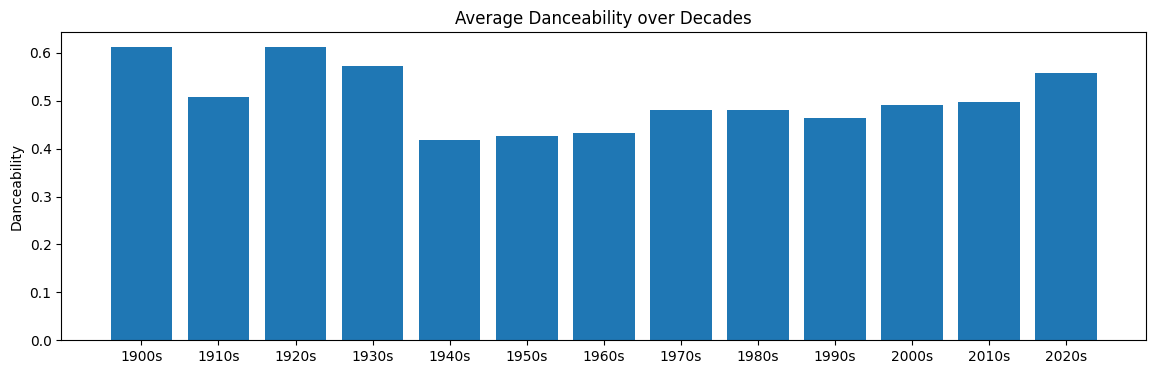

In [15]:
do_bar_plot_for_decade_of("danceability")

#### Bar Plots for Average Energy for Different Decades

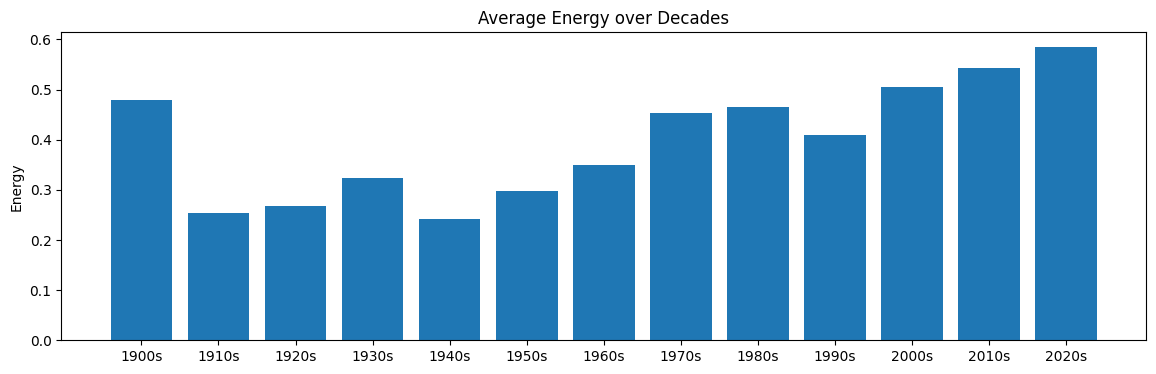

In [16]:
do_bar_plot_for_decade_of("energy")

#### Bar Plots for Average Intrumentalness for Different Decades

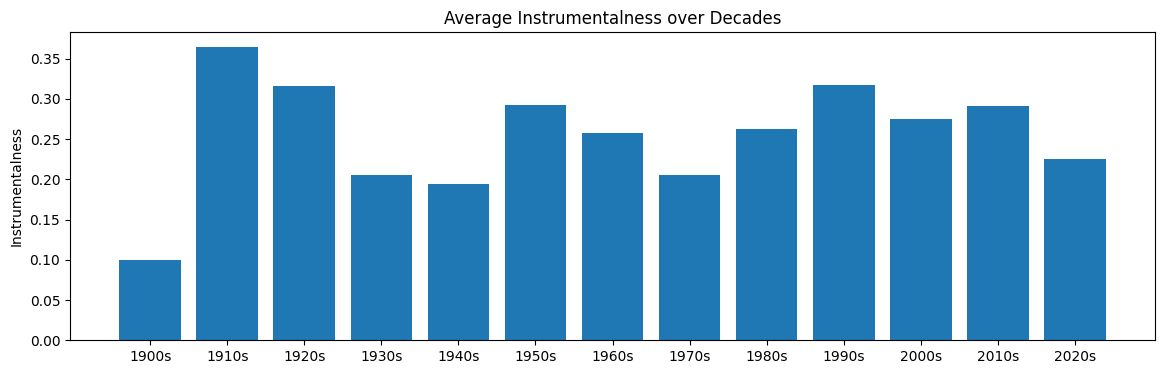

In [17]:
do_bar_plot_for_decade_of("instrumentalness")

#### Bar Plots for Average Loudness for Different Decades

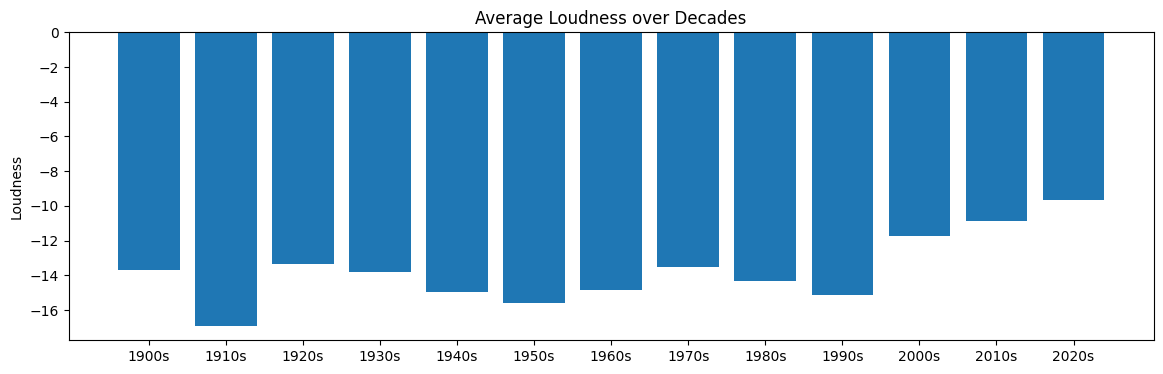

In [18]:
do_bar_plot_for_decade_of("loudness")

## Investigating Top-K Records

In [19]:
k = 10

### Top-k Tracks by Danceability

In [20]:
(df
 .select("name", "danceability")
 .orderBy(F.desc("danceability"))
 .limit(10)
 .show(truncate=False))

+------------------------------------+------------+
|name                                |danceability|
+------------------------------------+------------+
|Unendlich                           |1.0         |
|Na-try Mo Na Ba Ako                 |0.994       |
|Roll Like Dis / Cha-cha Slide Part 2|0.993       |
|Techno Is Not Fault                 |0.992       |
|Aussie, Aussie (O, Sige!)           |0.991       |
|Le casse-tête (Cannelle, Pruneau)   |0.991       |
|New Life                            |0.99        |
|Esther's Vice                       |0.99        |
|Go Nuts                             |0.988       |
|Believe In Love                     |0.988       |
+------------------------------------+------------+


### Top-k Artists with the Highest Average Danceability

In [21]:
(final_df
 .select(F.explode("artists").alias("artist"), "danceability")
 .groupBy("artist")
 .agg(F.avg("danceability").alias("avg_danceability"))
 .orderBy(F.desc("avg_danceability"))
 .limit(k)
 .show())

+------------------+----------------+
|            artist|avg_danceability|
+------------------+----------------+
|  Andrea HEinstein|           0.992|
|           Juelz B|           0.987|
|               Gen|           0.987|
|Audio Soul Project|           0.986|
|       LILDRUGHILL|           0.984|
|              Liêm|           0.983|
|          3rd Face|           0.981|
|        Money Maru|           0.981|
|       Lul Florida|            0.98|
|      Franko Murry|            0.98|
+------------------+----------------+


### Top-k Recent Tracks

In [22]:
(final_df
 .select("name", "release_date")
 .orderBy(F.desc("release_date"))
 .limit(k)
 .show(truncate=False))

+------------------------+------------+
|name                    |release_date|
+------------------------+------------+
|Red Cup                 |2020-12-18  |
|Red Cup - Radio Edit    |2020-12-18  |
|Red Cup - DJ Roody Remix|2020-12-18  |
|Red Cup - BTNZ Remix    |2020-12-18  |
|To the Beach            |2020-12-11  |
|Coma                    |2020-12-11  |
|Journey                 |2020-12-11  |
|Love                    |2020-12-11  |
|Away from You           |2020-12-11  |
|Absolutego              |2020-12-11  |
+------------------------+------------+


### Top-k Longest Tracks

In [23]:
(final_df
 .select("name", 
         F.col("duration").alias("duration_s"),
         F.col("minute"),
         F.col("second"),
         F.concat(F.format_string("%02d", "minute"), F.lit(":"), F.format_string("%02d", "second")).alias("duration"))
 .orderBy(F.desc("duration_s"))
 .limit(k)
 .show(truncate=False))

+---------------------------------------------------------------------------------------------------------------------------------------+----------+------+------+--------+
|name                                                                                                                                   |duration_s|minute|second|duration|
+---------------------------------------------------------------------------------------------------------------------------------------+----------+------+------+--------+
|Bargrooves Deluxe Edition 2018 Mix 2 - Continuous Mix                                                                                  |6061.09   |101   |1     |101:01  |
|Doctorow's Third Law                                                                                                                   |6054.655  |100   |54    |100:54  |
|Gothic Lolita                                                                                                                          |576

### Top-k Most Frequently Appearing Artists

In [24]:
(final_df
 .select(F.explode("artists").alias("artist"), "year")
 .groupBy("artist")
 .agg((F.count("artist") / (F.max("year") - F.min("year"))).alias("track_frequency"))
 .orderBy(F.desc("track_frequency"))
 .limit(k)
 .show(truncate=False))

+------------------------------------+---------------+
|artist                              |track_frequency|
+------------------------------------+---------------+
| Arthur Rubinstein                  |627.0          |
|Sing n Play                         |411.0          |
|TKKG                                |295.0          |
|Adventure Time                      |227.0          |
|Cavedoll                            |200.0          |
| Reginald Goodall                   |200.0          |
| Edith Haller                       |191.0          |
| Christa Mayer                      |187.0          |
| Giuseppe Bruno                     |185.0          |
| Amsterdam Baroque Orchestra & Choir|181.5          |
+------------------------------------+---------------+


In [25]:
# spark.stop()